<a href="https://colab.research.google.com/github/RodrigoEche/00_CoderHouseProyecto/blob/main/Desafio_APIs_Rodrigo_Echegoyemberry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Credenciales de usuario para usar la API generada en google cloud
api_key_youtube_RE = 'TU CLAVE DE ACTIVACION DE LA API'

In [ ]:
# Breve help de API de youtube
# 1. se tiene la api_key que nos da la google console cloud
# 2. somos clientes python de la google api de youtube importamos la libreria que proveen
# 3. crear instancia de api        ------------> api        = build(servicio_al_que_se_accede_con_la_api, version_api, clave_acceso)
# 4. configurar la solicitud/request        ---> request    = api.recurso().listar(que_queres_listar, con_que_criterio_busqueda, etc)
# 5. sabiendo que le vas a pedir se lo pedis --> respuesta  = request.execute() y esto vale unos puntos de cuota asignada
#
# en 4. recurso puede ser channels(), busqueda(), playlists(), preview() etc y se los puede listar(parametros) buscar(parametros) etc



# Obtener listado de videos de un usuario de youtube usando la API

In [1]:
# Fuente:
print('https://console.cloud.google.com/apis/api/youtube.googleapis.com/metrics?project=proyecto-api-youtube-clase-27&pageState=(%22duration%22:(%22groupValue%22:%22P1D%22,%22customValue%22:null))')

https://console.cloud.google.com/apis/api/youtube.googleapis.com/metrics?project=proyecto-api-youtube-clase-27&pageState=(%22duration%22:(%22groupValue%22:%22P1D%22,%22customValue%22:null))


In [ ]:
# Instalando libreria
!pip install google-api-python-client

In [3]:
# Nombres de usuarios de youtube
# raicesdeeuropa codigofacilito Lyna AuronPlay elrubius UskoKruM2010 CoderHouse voalearningenglish SeoulWalker
# pildorasinformaticas aaeemmhh  ArturoGeometria
usuario_de_youtube = 'caltech'
usuario_de_youtube

'caltech'

# Solicitud a la API via HTTP encapsulada dentro de la libreria provista por youtube

In [ ]:
# importo libreria para acceder a youtube siendo python client
from googleapiclient.discovery import build

# creo objeto api
api       = build('youtube','v3',developerKey = api_key_youtube_RE)

# armo que le voy a decir y qué recurso voy a querer listar, buscar, etc y de que usuario
solicitud = api.channels().list( part='statistics', forUsername = usuario_de_youtube )

# gasto parte de mi cuota en ejecutar la solicitud OJO
respuesta = solicitud.execute()

# visualizo la json-respuesta
respuesta

{'kind': 'youtube#channelListResponse',
 'etag': 'B6FHEmPIer2SN42_nEYS_wS2VPI',
 'pageInfo': {'totalResults': 1, 'resultsPerPage': 5},
 'items': [{'kind': 'youtube#channel',
   'etag': 'f0isCgviR9_w7F8rjc2PH6PGssc',
   'id': 'UClGTZDyz3CSl92TgDqIr0nw',
   'statistics': {'viewCount': '24576093',
    'subscriberCount': '178000',
    'hiddenSubscriberCount': False,
    'videoCount': '1603'}}]}

# Si el campo videoCount no es cero sigo con la extracción

In [ ]:
respuesta['items']

In [ ]:
# obtener el id del canal de youtube listado con list()     <--- se usa en la siguiente solicitud
id_canal_usuario_de_youtube = respuesta['items'][0]['id']
print(f'El ID del canal {usuario_de_youtube} es: {id_canal_usuario_de_youtube}')

El ID del canal caltech es: UClGTZDyz3CSl92TgDqIr0nw


# Opción1: Extrae urls y títulos de videos de un usuario

In [ ]:
# FUNCION PRINCIPAL DE EXTRACCION

# credencial de la api y eleccion del canal
API_KEY     = api_key_youtube_RE              # la generada desde google cloud
CHANNEL_ID  = id_canal_usuario_de_youtube      # id del canal

# funcion que obtiene los videos del canal
def get_channel_videos(channel_id):
    # construye objeto api y lo llama youtube
    youtube = build('youtube', 'v3', developerKey = API_KEY)
    videos = []
    next_page_token = None

    while True:
        # Arma la solicitud de search y listado de videos,
        # ordenados por fecha y en pagina de a 50 videos
        request = youtube.search().list(
            part='id',
            channelId=channel_id,
            maxResults=50,
            order='date',
            pageToken=next_page_token
        )
        # pide respuesta y gasta cuota
        response = request.execute()

        # Recorremos los resultados para obtener los IDs de los videos
        # y con esos IDs arma una solicitud usando el recurso video()
        # de la api usa el metodo lista, se queda con los snippets y de alli saca
        # las urls y titulos de los videos
        for item in response['items']:
            if item['id']['kind'] == 'youtube#video':
                video_id = item['id']['videoId']
                video_info = get_video_info(youtube, video_id)
                if video_info:
                    videos.append({
                        'title': video_info['title'],
                        'url': f'https://www.youtube.com/watch?v={video_id}',
                        'publishedAt': video_info['publishedAt']
                    })
        # Verificamos si hay más páginas de resultados
        next_page_token = response.get('nextPageToken')
        if not next_page_token:
            break

    return videos

# Funcion auxiliar
def get_video_info(youtube, video_id):
    # arma la solicitud usando el recurso video() de la api y pide snippet
    request = youtube.videos().list( part='snippet', id=video_id  )
    # pide respuestta
    response = request.execute()

    if 'items' in response and len(response['items']) > 0:
        return response['items'][0]['snippet']
    else:
        return None

# Llamada a la funcion de extraccion de urls de videos
if __name__ == '__main__':
    channel_id = CHANNEL_ID
    video_data = get_channel_videos(channel_id)

    # Imprimimos los títulos con un número antes
    for idx, video in enumerate(video_data, 1):
        print(f"{idx}. {video['title']}")
        print(f"        {video['url']}")
        print(f"        {video['publishedAt']}")

        print()
print(f' Fin del listado del canal: {usuario_de_youtube}')

# Toda la información extraida usando la API se guarda en el diccionario video_data

# Opción 2: Extrae TODA la info de los videos de un usuario (NO FUNCIONA)

In [ ]:
# Dado que se cobra por estos servicios no es posible extraer la informacion completa que hubiera enriquecido
# cualquier analisis posterior, pero igual se puede extraer informacion interesante con el numero de videos subidos a lo largo del tiempo

In [ ]:
from googleapiclient.discovery import build

# Credencial de la API y elección del canal
API_KEY = 'api_key_youtube_RE'  # Coloca aquí la API Key generada desde Google Cloud
CHANNEL_ID = 'id_canal_usuario_de_youtube'  # Coloca aquí el ID del canal de YouTube

# Función que obtiene los videos del canal
def get_channel_videos(channel_id):
    youtube = build('youtube', 'v3', developerKey=API_KEY)
    videos = []
    next_page_token = None

    while True:
        request = youtube.search().list(
            part='id',
            channelId=channel_id,
            maxResults=50,
            order='date',
            pageToken=next_page_token
        )
        response = request.execute()

        for item in response['items']:
            if item['id']['kind'] == 'youtube#video':
                video_id = item['id']['videoId']
                video_info = get_video_info(youtube, video_id)
                if video_info:
                    videos.append({
                        'title': video_info['snippet']['title'],
                        'url': f'https://www.youtube.com/watch?v={video_id}',
                        'publishedAt': video_info['snippet']['publishedAt'],
                        'viewCount': video_info['statistics']['viewCount'],
                        'likeCount': video_info['statistics']['likeCount'],
                        'dislikeCount': video_info['statistics']['dislikeCount'],
                        'commentCount': video_info['statistics']['commentCount'],
                        'favoriteCount': video_info['statistics']['favoriteCount'],
                        'country': video_info['snippet']['country'],
                        'duration': video_info['contentDetails']['duration'],
                        'dimension': video_info['contentDetails']['dimension'],
                        'caption': 'Yes' if video_info['contentDetails']['caption'] == 'true' else 'No',
                        'definition': video_info['contentDetails']['definition'],
                        'licensedContent': 'Yes' if video_info['contentDetails']['licensedContent'] == 'true' else 'No',
                        'privacyStatus': video_info['status']['privacyStatus'],
                        'embeddable': 'Yes' if video_info['status']['embeddable'] == 'true' else 'No',
                        'madeForKids': 'Yes' if video_info['status']['madeForKids'] == 'true' else 'No',
                        'tags': video_info['snippet']['tags'],
                        'categoryId': video_info['snippet']['categoryId'],
                        'description': video_info['snippet']['description']
                    })

        next_page_token = response.get('nextPageToken')
        if not next_page_token:
            break

    return videos

# Función auxiliar
def get_video_info(youtube, video_id):
    request = youtube.videos().list(part='snippet,statistics,contentDetails,status', id=video_id)
    response = request.execute()

    if 'items' in response and len(response['items']) > 0:
        return response['items'][0]
    else:
        return None

if __name__ == '__main__':
    channel_id = CHANNEL_ID
    video_data = get_channel_videos(channel_id)

    # Imprimimos los datos de los videos
    for idx, video in enumerate(video_data, 1):
        print(f"{idx}. {video['title']}")
        print(f"   URL: {video['url']}")
        print(f"   Fecha de publicación: {video['publishedAt']}")
        print(f"   Vistas: {video['viewCount']}")
        print(f"   Me gusta: {video['likeCount']}")
        print(f"   No me gusta: {video['dislikeCount']}")
        print(f"   Comentarios: {video['commentCount']}")
        print(f"   Favoritos: {video['favoriteCount']}")
        print(f"   País: {video['country']}")
        print(f"   Duración: {video['duration']}")
        print(f"   Dimensiones: {video['dimension']}")
        print(f"   Subtítulos: {video['caption']}")
        print(f"   Definición: {video['definition']}")
        print(f"   Contenido con licencia: {video['licensedContent']}")
        print(f"   Estado de privacidad: {video['privacyStatus']}")
        print(f"   Incrustable: {video['embeddable']}")
        print(f"   Hecho para niños: {video['madeForKids']}")
        print(f"   Etiquetas: {video['tags']}")
        print(f"   Categoría: {video['categoryId']}")
        print(f"   Descripción: {video['description']}")
        print()

print(f' Fin del listado del canal: {usuario_de_youtube}')


HttpError: ignored

# Grabar permanentemente listado de videos

In [ ]:
# el diccionario video_data contiene toda la informacion extraida a un usuario particular
# dado que esa información es volatil en memoria se la guardará en una única base de datos sqlite
# donde se creara o actualizara una tabla completa con los datos de un unico usuario, el nombre de la tabla
# es el nombre de usuario.


In [ ]:
video_data

In [ ]:
import pandas as pd
df = pd.DataFrame(video_data)
df

,title,url,publishedAt
0,Circunferencia Inversa de otra dada Interior a...,https://www.youtube.com/watch?v=M59iqWSyZlg,2023-06-25T13:00:13Z
1,Clase de Oposiciones a Secundaria Dibujo 26 - ...,https://www.youtube.com/watch?v=xWenMyzSI_Y,2023-06-22T06:34:13Z
2,Clase de Oposiciones a Secundaria Dibujo 25 - ...,https://www.youtube.com/watch?v=hwF3CAoeCow,2023-06-21T06:39:08Z
3,Circunferencia Inversa de otra dada Interior a...,https://www.youtube.com/watch?v=M0b2pYvLPK0,2023-06-20T15:00:24Z
4,Circunferencia Doble de 2 Circunferencias dada...,https://www.youtube.com/watch?v=NCDQ2JLDss4,2023-06-15T15:00:18Z
...,...,...,...
492,Heptágono regular dado su lado,https://www.youtube.com/watch?v=kLK1BUPgcAU,2013-11-10T10:34:22Z
493,División de un ángulo recto en tres ángulos ig...,https://www.youtube.com/watch?v=gWfcArdhHUI,2013-10-10T15:00:02Z
494,Ángulo igual a otro dado,https://www.youtube.com/watch?v=kTwCrVDMaIg,2013-10-08T15:00:01Z
495,Circunferencia que pasa por tres puntos no ali...,https://www.youtube.com/watch?v=1UYfMcQYPvc,2013-10-06T15:00:02Z


In [ ]:
# Antes de almacenar en sqlite se convierte a DataFrame, se ordenan los registros por fecha, se regenera el indice,
# se crea una columna con el indice+1 y esa columna representará el número de videos subidos y acumulados a lo largo del tiempo
# Recien ahi se guarda en csv, excel y sqlite.

df['publishedAt'] = pd.to_datetime(df['publishedAt']).dt.tz_localize(None)
df                = df.sort_values('publishedAt',ascending =True)
df                = df.reset_index(drop=True)
# Agregar el índice como una nueva columna en el DataFrame
df.reset_index(drop=False, inplace=True)

df.rename(columns={'index': 'videos subidos','title':'titulo', 'url': 'direccion','publishedAt': 'publicado'}, inplace=True)
df['videos subidos'] = df.index + 1
df

,videos subidos,titulo,direccion,publicado
0,1,Bisectriz de un ángulo,https://www.youtube.com/watch?v=1b8GPGamYfI,2013-09-23 17:05:31
1,2,Circunferencia que pasa por tres puntos no ali...,https://www.youtube.com/watch?v=1UYfMcQYPvc,2013-10-06 15:00:02
2,3,Ángulo igual a otro dado,https://www.youtube.com/watch?v=kTwCrVDMaIg,2013-10-08 15:00:01
3,4,División de un ángulo recto en tres ángulos ig...,https://www.youtube.com/watch?v=gWfcArdhHUI,2013-10-10 15:00:02
4,5,Heptágono regular dado su lado,https://www.youtube.com/watch?v=kLK1BUPgcAU,2013-11-10 10:34:22
...,...,...,...,...
492,493,Circunferencia Doble de 2 Circunferencias dada...,https://www.youtube.com/watch?v=NCDQ2JLDss4,2023-06-15 15:00:18
493,494,Circunferencia Inversa de otra dada Interior a...,https://www.youtube.com/watch?v=M0b2pYvLPK0,2023-06-20 15:00:24
494,495,Clase de Oposiciones a Secundaria Dibujo 25 - ...,https://www.youtube.com/watch?v=hwF3CAoeCow,2023-06-21 06:39:08
495,496,Clase de Oposiciones a Secundaria Dibujo 26 - ...,https://www.youtube.com/watch?v=xWenMyzSI_Y,2023-06-22 06:34:13


In [ ]:
# Montar drive para guardar permanentemente los archivos
from google.colab import drive
import os
drive.mount('/content/gdrive')

import os
print(os.getcwd())
os.chdir("/content/gdrive/My Drive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).
/content/gdrive/My Drive


In [ ]:
usuario_de_youtube

'ArturoGeometria'

In [ ]:
# Guardar en CSV, Excel y HTML montar antes drive para guardar en su raiz permanentemmente
df.to_csv   (  f'youtube_{usuario_de_youtube}.csv',   index=False  )
df.to_excel (  f'youtube_{usuario_de_youtube}.xlsx',  index=False  )
df.to_html  (  f'youtube_{usuario_de_youtube}.html',  index=False  )

In [ ]:
# Guardar en base de datos
import sqlite3

# nombre base datos que contendrá una tabla para cada usuario
# la tabla se sobreescribira si hay nuevos datos, la base es siempre a misma
base  = 'youtube_videos_canales.sqlite'
tabla = usuario_de_youtube

conn = sqlite3.connect(base)
df.to_sql (    f'{tabla}', conn, index = False, if_exists = 'replace')

497

In [ ]:
# cerrar conexion a la base de datos
conn.close()

# Analisis de los datos a partir de base de datos guardada en drive

In [ ]:
# El análisis de datos se hacen con todos los usuarios almacenados en la base de datos
# leyendo cada tabla de la base, guardandola en una estructura de diccionario de dataframes,
# extrayendo de cada dataframe dos columnas tiempo y numero de videos acumulados
# se grafican las evoluciones todas juntaas para comparar.

In [ ]:
# Montar drive para cargar la base
from google.colab import drive
import os
drive.mount('/content/gdrive')

import os
print(os.getcwd())
os.chdir("/content/gdrive/My Drive")

Mounted at /content/gdrive
/content


In [ ]:
# Conectarse a la base de datos
base = 'youtube_videos_canales.sqlite'
ruta = '/content/gdrive/MyDrive/'
base = ruta + base

import sqlite3
conn = sqlite3.connect(base)

# Crear un cursor para acceder a la tabla a traves de la conexion
cursor = conn.cursor()

# Listar tablas dentro de la base

In [ ]:
#  Listar las tablas existentes en la base de datos
def listar_tablas(conexion):
  cursor = conexion.cursor()
  cursor.execute("SELECT name FROM sqlite_master WHERE type='table'")
  tables = cursor.fetchall()
  print(len(tables), "tabla/s: ")
  for table in tables:
    print("Tabla --> ", table[0])

listar_tablas(conn)

10 tabla/s: 
Tabla -->  raicesdeeuropa
Tabla -->  elrubius
Tabla -->  voalearningenglish
Tabla -->  SeoulWalker
Tabla -->  codigofacilito
Tabla -->  UskoKruM2010
Tabla -->  pildorasinformaticas
Tabla -->  aaeemmhh
Tabla -->  merchemarques
Tabla -->  ArturoGeometria


# Extraer tablas de la base y asignar al diccionario de dataframes dfs

In [ ]:
import sqlite3
import pandas as pd

# Función para obtener un DataFrame a partir de una tabla en la base de datos
def obtener_dataframe_desde_tabla(conexion, nombre_tabla):
    query = f"SELECT * FROM {nombre_tabla}"
    df = pd.read_sql_query(query, conexion)
    return df

# Función para obtener un diccionario de DataFrames
def obtener_diccionario_dataframes(conexion):
    cursor = conexion.cursor()
    cursor.execute("SELECT name FROM sqlite_master WHERE type='table'")
    tables = cursor.fetchall()

    dfs = {}
    for table in tables:
        nombre_tabla = table[0]
        df = obtener_dataframe_desde_tabla(conexion, nombre_tabla)
        dfs[nombre_tabla] = df

    return dfs

# Conexión a la base de datos (suponiendo que la base de datos se llama 'mi_basededatos.db')
conn = sqlite3.connect(base)

# Obtener el diccionario de DataFrames
dfs = obtener_diccionario_dataframes(conn)

# Cerrar la conexión
conn.close()

# Ahora puedes acceder a los DataFrames utilizando el nombre de las tablas como claves del diccionario 'dfs'
# Por ejemplo, para obtener el DataFrame correspondiente a la tabla 'tabla1':
# df_tabla1 = dfs['tabla1']

# Para imprimir la información de cada DataFrame:
'''
for nombre_tabla, df in dfs.items():
    print(f"Tabla: {nombre_tabla}")
    print(df, '\n')
'''


Tabla: raicesdeeuropa
     videos subidos                                             titulo  \
0                 1  Japón: cultura y actualidad. Makiko Morimoto y...   
1                 2  Japón: cultura y actualidad. Makiko Morimoto y...   
2                 3  Sebastian Iradier: el compositor olvidado. Sab...   
3                 4  Sebastian Iradier: el compositor olvidado. Sab...   
4                 5  Ley y derecho en el Imperio Romano. José Ramón...   
..              ...                                                ...   
478             479  El Misántropo de Menandro. Eva Tobalina nos ac...   
479             480  ÉBANO de Kapuscinski, la genial creación sobre...   
480             481  Grandes libros. ORTODOXIA de Chesterton, obra ...   
481             482  Grandes libros. MISERICORDIA de Pérez Galdos, ...   
482             483  Grandes Yacimientos IV. Stonehenge: historia y...   

                                       direccion            publicado  
0    https://www.

# Graficar serie temporal de número de videos subidos por cada usuario

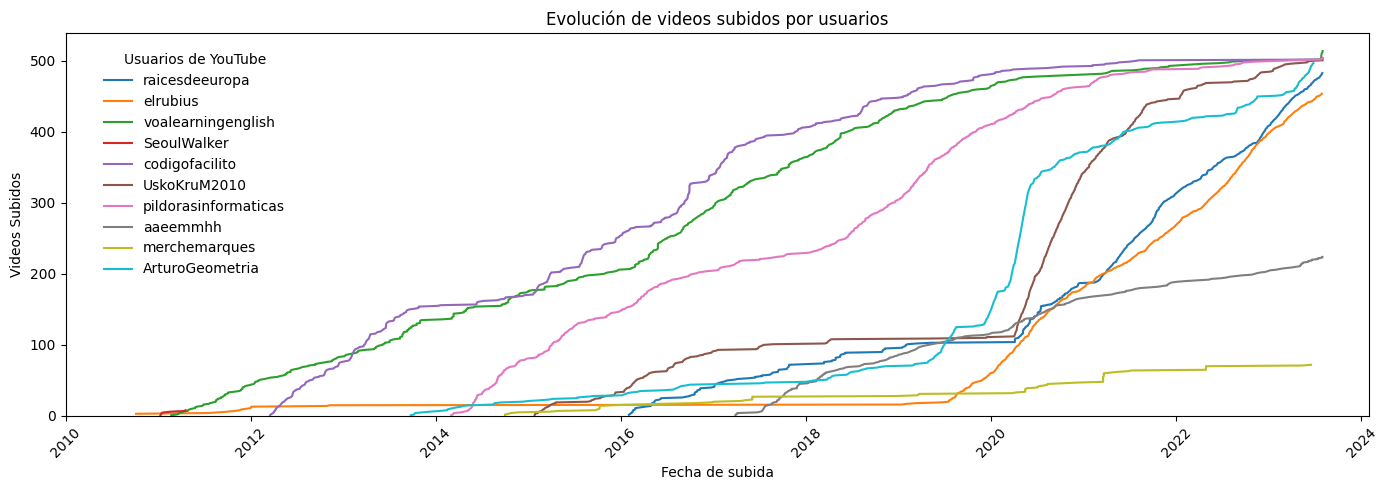

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Establecer los límites del eje de tiempo
fecha_inicio = pd.to_datetime('2010-01-01')
fecha_fin = pd.to_datetime('2024-01-31')

# Crear una lista para almacenar todos los DataFrames
dfs_list = []

# Unir todos los DataFrames en un solo DataFrame y agregar el nombre de usuario como columna
for nombre_usuario, df in dfs.items():
    df['nombreUsuario'] = nombre_usuario
    dfs_list.append(df)

# Combinar todos los DataFrames en un solo DataFrame
dfs_concatenados = pd.concat(dfs_list)

# Convertir la columna "publicado" a Timestamp si está en formato de cadena
if isinstance(dfs_concatenados['publicado'].iloc[0], str):
    dfs_concatenados['publicado'] = pd.to_datetime(dfs_concatenados['publicado'])

# Filtrar el DataFrame combinado por las fechas dentro del rango
dfs_filtrados = dfs_concatenados[(dfs_concatenados['publicado'] >= fecha_inicio) & (dfs_concatenados['publicado'] <= fecha_fin)]

# Graficar todas las curvas de evolución de la columna "videosSubidos" en el eje de tiempo
plt.figure(figsize=(14, 5))
sns.lineplot(x='publicado', y='videos subidos', hue='nombreUsuario', data=dfs_filtrados)
plt.title('Evolución de videos subidos por usuarios')
plt.xlabel('Fecha de subida')
plt.ylabel('Videos Subidos')
plt.xticks(rotation=45)
plt.ylim(0, None)  # Establecer límite inferior del eje Y a 0
plt.xlim(fecha_inicio, fecha_fin)  # Establecer límites del eje X
plt.legend(title='Usuarios de YouTube', loc='upper left', bbox_to_anchor=(0.02, 0.98), frameon=False)
plt.tight_layout()  # Ajustar el espacio para que las leyendas no se recorten
plt.show()


In [ ]:
# Dado que hay claros puntos de inflexion se tratara de hallar una explicación solamente a partir de la unica
# columna de informacion que es el titulo que el usuario asignó al video (habría mas columnas en la versión paga de la api)
# Mi hipotesis es que tal vez a través de los títulos se puede extraer unas palabras que por su frecuencia o aparición respecto
# al tiempo en que ocurre la inflexion de la curva de unn usuario en particular se pueda encontrar una explicacion a ese comportamiento
# de crecimiento acelerado en los videos subidos. El analisis que se me ocurre es extraer los sustantivos de la oración y hacer un conteo
# y observar el momento en que aparecen. Por ejemplo supongamos que en los titulos de "elrubius" encontrara que la palabra "Minecraft" aparece por
# primera vez en el aaño 2019 y luego se repite muchaas veces a partir de alli en los titulos de los videos que sube, eso podria indicar
# una relacion y tal vez una explicacion del comportamiento. Lo que sigue es un intento de separar en columnas los sustantivos, esten en ingles o español,
# y tratar de buscar unna causa, pero aun esta en proceso.


In [ ]:
df1 = list(dfs.values())[0]
df1


,videos subidos,titulo,direccion,publicado
0,1,Japón: cultura y actualidad. Makiko Morimoto y...,https://www.youtube.com/watch?v=fOK7Q-YMMIg,2016-02-01 16:08:55
1,2,Japón: cultura y actualidad. Makiko Morimoto y...,https://www.youtube.com/watch?v=fOK7Q-YMMIg,2016-02-01 16:08:55
2,3,Sebastian Iradier: el compositor olvidado. Sab...,https://www.youtube.com/watch?v=XqTFdQOEZ6A,2016-02-08 15:45:45
3,4,Sebastian Iradier: el compositor olvidado. Sab...,https://www.youtube.com/watch?v=XqTFdQOEZ6A,2016-02-08 15:45:45
4,5,Ley y derecho en el Imperio Romano. José Ramón...,https://www.youtube.com/watch?v=6aBo3pd5gtA,2016-02-15 10:08:16
...,...,...,...,...
478,479,El Misántropo de Menandro. Eva Tobalina nos ac...,https://www.youtube.com/watch?v=XUikUbb9bdE,2023-07-23 14:00:08
479,480,"ÉBANO de Kapuscinski, la genial creación sobre...",https://www.youtube.com/watch?v=Eia-jLtHYrA,2023-07-25 15:00:11
480,481,"Grandes libros. ORTODOXIA de Chesterton, obra ...",https://www.youtube.com/watch?v=9AE75Ycw5D0,2023-07-27 15:00:08
481,482,"Grandes libros. MISERICORDIA de Pérez Galdos, ...",https://www.youtube.com/watch?v=vS5-iMvGvg0,2023-07-29 15:00:07


In [ ]:
!pip install spacy

!# Descarga el modelo en español
!python -m spacy download es_core_news_sm

# Descarga el modelo en inglés
!python -m spacy download en_core_web_sm

!pip install langdetect


In [ ]:
import spacy
import pandas as pd
from langdetect import detect

# Extrae de la oración del titulo el sustantivo y genera nueva columna

In [ ]:
# Carga el modelo de spaCy para inglés
nlp_en = spacy.load("en_core_web_sm")

# Carga el modelo de spaCy para español
nlp_es = spacy.load("es_core_news_sm")

# Función para detectar el idioma de una oración
def detect_language(text):
    return detect(text)

# Función para extraer sustantivos y verbos de una oración
def extraer_sustantivos(text):
    lang = detect_language(text)
    nlp = nlp_en if lang == "en" else nlp_es
    doc = nlp(text)
    nouns = ", ".join([token.text for token in doc if token.pos_ == "NOUN"])
    #verbs = ", ".join([token.text for token in doc if token.pos_ == "VERB"])
    return nouns

# DataFrame de ejemplo
data = {
    "Titulo": [
        "El gato corre velozmente.",
        "The sun shines brightly.",
        "La casa es grande y bonita.",
        "The dog barks loudly.",
    ]
}

df = pd.DataFrame(df1)

# Agregar las columnas "Sustantivo" y "Verbo" al DataFrame
df["Sustantivo2"] = df["titulo"].apply(extraer_sustantivos)

# Muestra el resultado
df


,videos subidos,titulo,direccion,publicado,Sustantivo,Verbo,Sustantivo2
0,1,Japón: cultura y actualidad. Makiko Morimoto y...,https://www.youtube.com/watch?v=fOK7Q-YMMIg,2016-02-01 16:08:55,"cultura, actualidad",,"cultura, actualidad"
1,2,Japón: cultura y actualidad. Makiko Morimoto y...,https://www.youtube.com/watch?v=fOK7Q-YMMIg,2016-02-01 16:08:55,"cultura, actualidad",,"cultura, actualidad"
2,3,Sebastian Iradier: el compositor olvidado. Sab...,https://www.youtube.com/watch?v=XqTFdQOEZ6A,2016-02-08 15:45:45,compositor,,compositor
3,4,Sebastian Iradier: el compositor olvidado. Sab...,https://www.youtube.com/watch?v=XqTFdQOEZ6A,2016-02-08 15:45:45,compositor,,compositor
4,5,Ley y derecho en el Imperio Romano. José Ramón...,https://www.youtube.com/watch?v=6aBo3pd5gtA,2016-02-15 10:08:16,derecho,,derecho
...,...,...,...,...,...,...,...
478,479,El Misántropo de Menandro. Eva Tobalina nos ac...,https://www.youtube.com/watch?v=XUikUbb9bdE,2023-07-23 14:00:08,obra,,obra
479,480,"ÉBANO de Kapuscinski, la genial creación sobre...",https://www.youtube.com/watch?v=Eia-jLtHYrA,2023-07-25 15:00:11,"ÉBANO, creación, reportero, siglo, XX",,"ÉBANO, creación, reportero, siglo, XX"
480,481,"Grandes libros. ORTODOXIA de Chesterton, obra ...",https://www.youtube.com/watch?v=9AE75Ycw5D0,2023-07-27 15:00:08,"libros, ORTODOXIA, obra, ensayista",,"libros, ORTODOXIA, obra, ensayista"
481,482,"Grandes libros. MISERICORDIA de Pérez Galdos, ...",https://www.youtube.com/watch?v=vS5-iMvGvg0,2023-07-29 15:00:07,"libros, obra, literatura",,"libros, obra, literatura"
